# Import Core Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import pickle

from os import listdir, walk
from os.path import isfile, join

In [2]:
from detect_peaks import detect_peaks
import ruptures as rpt

# Load Dataset

In [3]:
%run load_dataset.ipynb

In [144]:
train_normal = [str(i) for i in range(1001,1012)]
train_patients = [str(i) for i in range(3001,3005)]

test_normal = ['1012','2002']
test_patients = ['2001','3005']

# train_set = np.hstack((train_normal, train_patients))
# test_set = np.hstack((test_normal, test_patients))

train_set = train_patients
test_set = test_patients

In [145]:
train_patients

['3001', '3002', '3003', '3004']

In [146]:
len(train_set), len(test_set)

(4, 2)

In [147]:
X_tr, y_tr, subj_tr, ts_tr, hs_tr = load_all_data(train_patients)

Loading 3001's data
Loading 3002's data
Loading 3003's data
Loading 3004's data
Finished loading


In [148]:
X_tes, y_tes, subj_tes, ts_tes, hs_tes = load_all_data(test_patients)

Loading 2001's data
Loading 3005's data
Finished loading


# Data Preprocessing

In [150]:
%run preprocessing.ipynb

# Group Data by Label and Normalize Data

In [151]:
print(label_list)
print(label_dict)

['sit', 'sleep', 'stand', 'walk']
{'sit': 0, 'sleep': 1, 'stand': 2, 'walk': 3}


In [152]:
new_label_list = [0,1,2,3]
new_label_dict = {
    0: 'sit',
    1: 'sleep',
    2: 'stand',
    3: 'walk'
}

colors = ['r','g','b','navy','turquoise','darkorange']

In [153]:
# group X_all and y_all from load_dataset.ipynb by labels
X_label, y_label = label_grouping(X_tr, y_tr, subj_tr, train_set, new_label_list)

# normalize X_label
X_norm = normalize_data(X_label)

## Show Plot for each Activity and Subject

In [154]:
# plot_all_label(X_label, y_all, new_label_list, new_label_dict)

# Calculate Roll, Pitch, Yaw

In [155]:
roll, pitch, yaw = calc_rpy(X_tr, colors)
rpy_tr = np.array([roll, pitch, yaw]).transpose()

print(rpy_tr.shape, y_tr.shape)

(6761, 3) (6761,)


In [156]:
roll, pitch, yaw = calc_rpy(X_tes, colors)
rpy_tes = np.array([roll, pitch, yaw]).transpose()

print(rpy_tes.shape, y_tes.shape)

(4237, 3) (4237,)


# Apply PCA

## Training Set

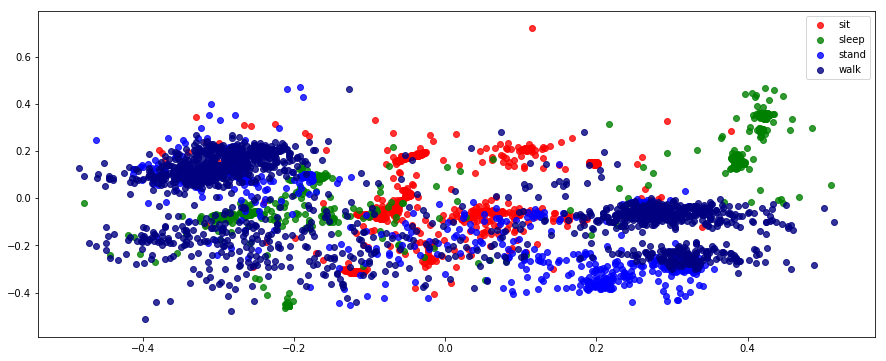

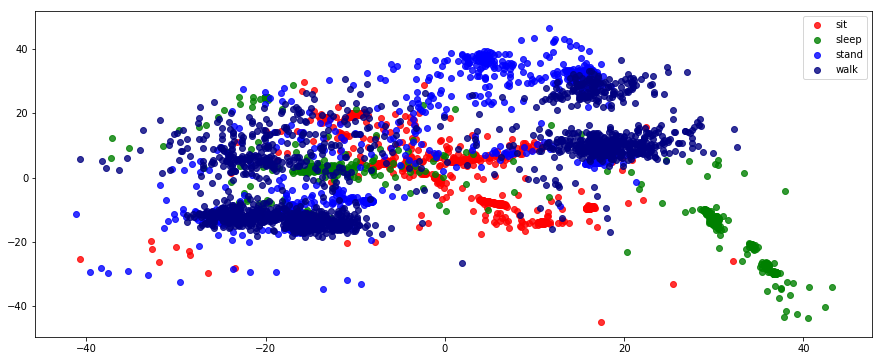

In [157]:
# apply PCA and LDA to X_all and rpy
X_pca_tr, pca_tr = apply_pca(X_tr, y_tr, label_list)
rpy_pca_tr, pca_rpy = apply_pca(rpy_tr, y_tr, label_list)

## Test Set

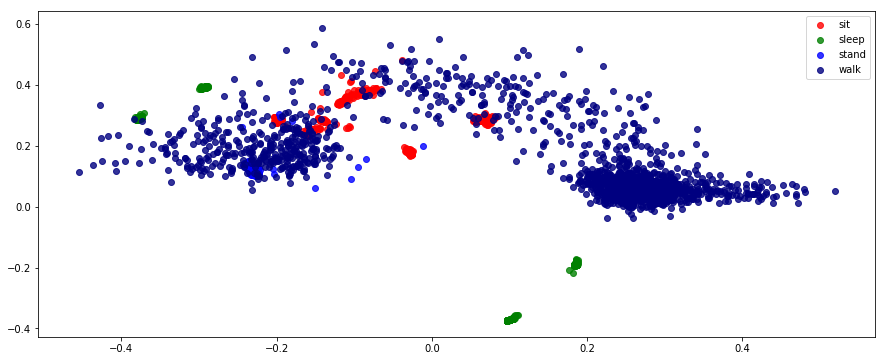

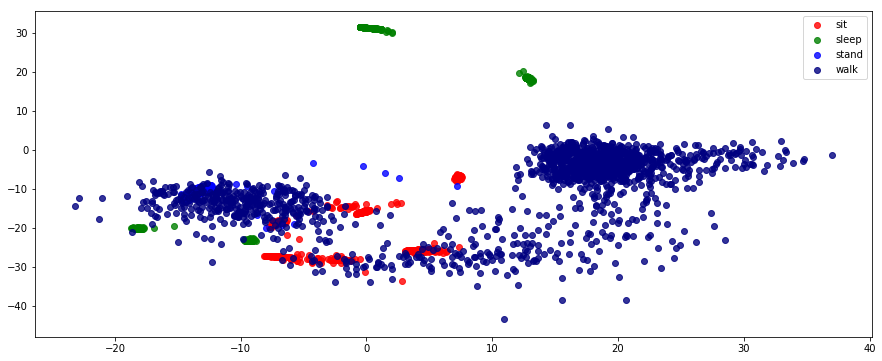

In [158]:
X_pca_tes = pca_tr.transform(X_tes)

lw = 1
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)

for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5], label_list): 

    ax.scatter(X_pca_tes[np.where(y_tes==i), 0], X_pca_tes[np.where(y_tes==i), 1],
               color=color, alpha=.8, linewidths=lw, label=target_name)
    ax.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()
plt.close(fig)

rpy_pca_tes = pca_rpy.transform(rpy_tes)

lw = 1
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)

for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5], label_list): 

    ax.scatter(rpy_pca_tes[np.where(y_tes==i), 0], rpy_pca_tes[np.where(y_tes==i), 1],
               color=color, alpha=.8, linewidths=lw, label=target_name)
    ax.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()
plt.close(fig)

# Reshape Data (Pure Label)

In [159]:
# get label-separated X and y
X_pure, y_pure = prepare_pure_label(X_tr, y_tr, subj_tr, train_set, new_label_list)
y_pure = y_pure.reshape((y_pure.shape[0],))

In [160]:
print(X_pure.shape, y_pure.shape)

(5817, 180) (5817,)


# Reshape Data (Impure Label)

In [161]:
X_impure, y_impure = prepare_impure_label(X_tr, y_tr)

In [162]:
print(X_impure.shape, y_impure.shape)

(6702, 180) (6702,)


# Split Train and Test Set

In [163]:
# Split training data and testing data
X_train = X_pure
y_train = y_pure

In [164]:
X_test, y_test = prepare_pure_label(X_tes, y_tes, subj_tes, test_set, new_label_list)
y_test = y_test.reshape((y_test.shape[0],))

In [165]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5817, 180) (5817,)
(3765, 180) (3765,)


In [166]:
X_test

array([[0.48, 0.47, 0.46, ..., 0.63, 0.63, 0.63],
       [0.47, 0.46, 0.46, ..., 0.63, 0.63, 0.63],
       [0.46, 0.46, 0.47, ..., 0.63, 0.63, 0.63],
       ...,
       [0.72, 0.81, 0.77, ..., 0.6 , 0.65, 0.67],
       [0.81, 0.77, 0.7 , ..., 0.65, 0.67, 0.65],
       [0.77, 0.7 , 0.74, ..., 0.67, 0.65, 0.65]])

# K-Nearest Neighbors

In [167]:
%run eval_score.ipynb

In [168]:
label_list

['sit', 'sleep', 'stand', 'walk']

In [170]:
nn_model = nn_classifier(X_train, y_train, k=3)
print("Finished training")

Finished training


In [171]:
filename = basepath + 'model/knn_model_split.pkl'
pickle.dump(nn_model, open(filename, 'wb'))

In [172]:
y_pred = nn_model.predict(X_test)

## Evaluation

In [173]:
%run eval_score.ipynb

In [174]:
LABELS = ['sit','sleep','stand','walk']

0.46268260292164676


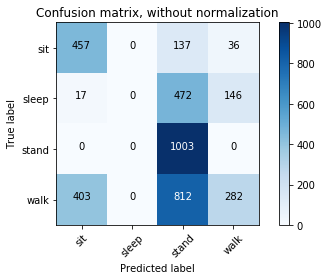

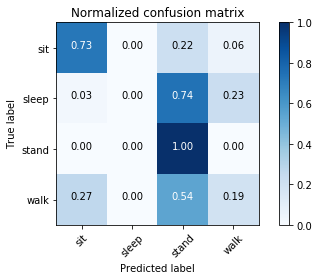

              precision    recall  f1-score   support

         sit       0.52      0.73      0.61       630
       sleep       0.00      0.00      0.00       635
       stand       0.41      1.00      0.59      1003
        walk       0.61      0.19      0.29      1497

   micro avg       0.46      0.46      0.46      3765
   macro avg       0.39      0.48      0.37      3765
weighted avg       0.44      0.46      0.37      3765



E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [175]:
acc = accuracy_score(y_test, y_pred)
print(acc)

show_conf_matrix(y_test, y_pred, LABELS)
show_clf_report(y_test, y_pred, LABELS)

# Walk Algorithm

In [176]:
%run classifier_alg.ipynb

In [177]:
X_dict = {
    'id': subj_tr,
    'x': [X_i[0] for X_i in X_tr],
    'y': [X_i[1] for X_i in X_tr],
    'z': [X_i[2] for X_i in X_tr],
    'x_pca': [X_i_pca[0] for X_i_pca in X_pca_tr],
    'y_pca': [X_i_pca[1] for X_i_pca in X_pca_tr],
    'z_pca': [X_i_pca[2] for X_i_pca in X_pca_tr],
    'label': y_tr
}

df_rpy = pd.DataFrame(X_dict)

In [178]:
# cols = ['x_pca', 'y_pca', 'z_pca']
cols = ['x', 'y', 'z']

df_pca = df_rpy[cols]     # training set

In [179]:
xyz_pca = np.array(df_pca.to_dict(orient='split')['data'])
dummy_y = np.array([-1 for i in range(len(xyz_pca))])

In [180]:
xyz_pca, y_temp = make_overlapping(xyz_pca, dummy_y)

In [181]:
xyz_pca.shape, df_pca.shape

((6702, 60, 3), (6761, 3))

In [182]:
walk_pred = classify_walk_2(xyz_pca)
walk_pred = np.array(walk_pred)

In [183]:
walk_pred

array([0, 0, 0, ..., 3, 3, 3])

In [184]:
walk_actual = np.array([3 if (df_rpy.loc[i, 'label']==3) else 0 for i in range(len(df_rpy))])

walk_actual.shape

(6761,)

In [185]:
print(walk_actual)

[0 0 0 ... 3 3 3]


## Walk Algorithm Evaluation

In [186]:
walk_lbl = ['NaN','walk']

0.8849597135183527


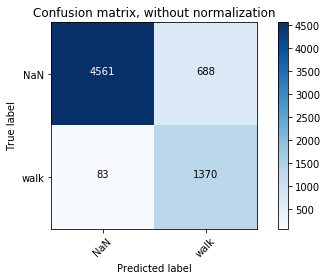

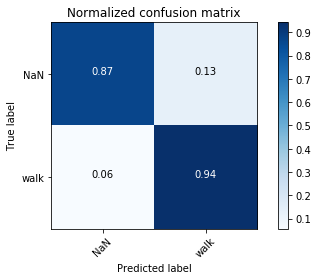

              precision    recall  f1-score   support

         NaN       0.98      0.87      0.92      5249
        walk       0.67      0.94      0.78      1453

   micro avg       0.88      0.88      0.88      6702
   macro avg       0.82      0.91      0.85      6702
weighted avg       0.91      0.88      0.89      6702



In [187]:
acc = accuracy_score(walk_actual[:walk_pred.shape[0]], walk_pred)
print(acc)

show_conf_matrix(walk_actual[:walk_pred.shape[0]], walk_pred, walk_lbl)
show_clf_report(walk_actual[:walk_pred.shape[0]], walk_pred, walk_lbl)

# Combine SVM and Walk Algorithm

In [188]:
X_test_new = get_inverse_X(X_test)

X_test_new

array([[[0.48, 0.23, 0.63],
        [0.47, 0.24, 0.64],
        [0.46, 0.27, 0.63],
        ...,
        [0.47, 0.24, 0.63],
        [0.47, 0.24, 0.63],
        [0.47, 0.24, 0.63]],

       [[0.47, 0.24, 0.64],
        [0.46, 0.27, 0.63],
        [0.46, 0.22, 0.61],
        ...,
        [0.47, 0.24, 0.63],
        [0.47, 0.24, 0.63],
        [0.47, 0.24, 0.63]],

       [[0.46, 0.27, 0.63],
        [0.46, 0.22, 0.61],
        [0.47, 0.24, 0.63],
        ...,
        [0.47, 0.24, 0.63],
        [0.47, 0.24, 0.63],
        [0.47, 0.24, 0.63]],

       ...,

       [[0.72, 0.42, 0.58],
        [0.81, 0.42, 0.63],
        [0.77, 0.4 , 0.65],
        ...,
        [0.72, 0.43, 0.6 ],
        [0.92, 0.52, 0.65],
        [0.84, 0.46, 0.67]],

       [[0.81, 0.42, 0.63],
        [0.77, 0.4 , 0.65],
        [0.7 , 0.39, 0.67],
        ...,
        [0.92, 0.52, 0.65],
        [0.84, 0.46, 0.67],
        [0.73, 0.52, 0.65]],

       [[0.77, 0.4 , 0.65],
        [0.7 , 0.39, 0.67],
        [0.74, 0

In [189]:
walk_pred = classify_walk_2(X_test_new)

In [190]:
y_pred_new = combine_2(X_test_new, y_pred)

0.7219123505976096


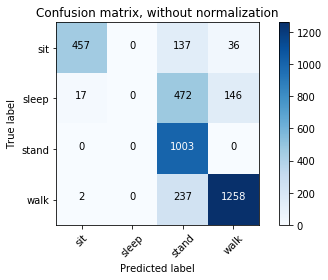

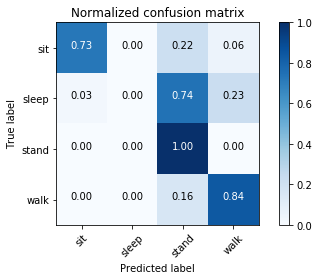

              precision    recall  f1-score   support

         sit       0.96      0.73      0.83       630
       sleep       0.00      0.00      0.00       635
       stand       0.54      1.00      0.70      1003
        walk       0.87      0.84      0.86      1497

   micro avg       0.72      0.72      0.72      3765
   macro avg       0.59      0.64      0.60      3765
weighted avg       0.65      0.72      0.67      3765



E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [191]:
acc = accuracy_score(y_test, y_pred_new)
print(acc)

show_conf_matrix(y_test, y_pred_new, label_list)
show_clf_report(y_test, y_pred_new, label_list)

# Test Model with Some Subjects

In [192]:
%run test_model.ipynb

In [193]:
filename = basepath + 'model/knn_model_split.pkl'

model = pickle.load(open(filename,'rb'))

In [194]:
LABELS = label_list
LABELS

['sit', 'sleep', 'stand', 'walk']

Loading 2001's data
Finished prediction


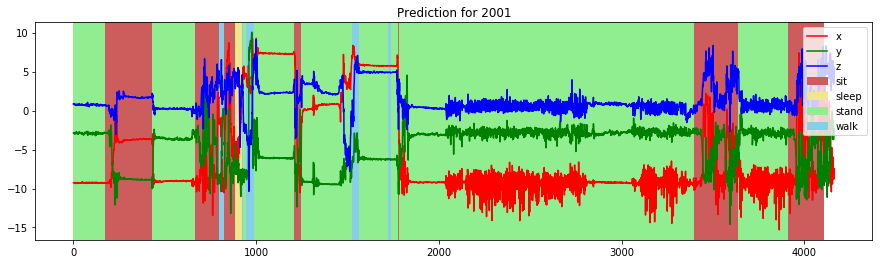

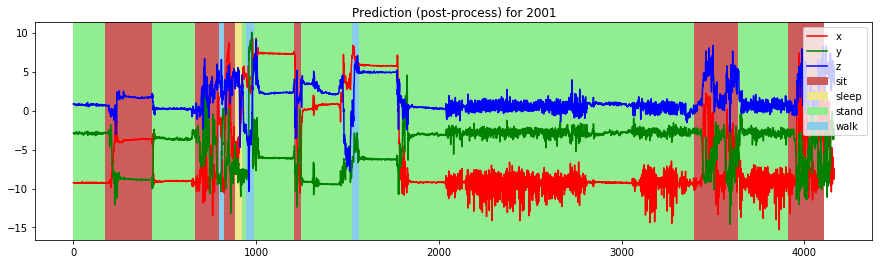

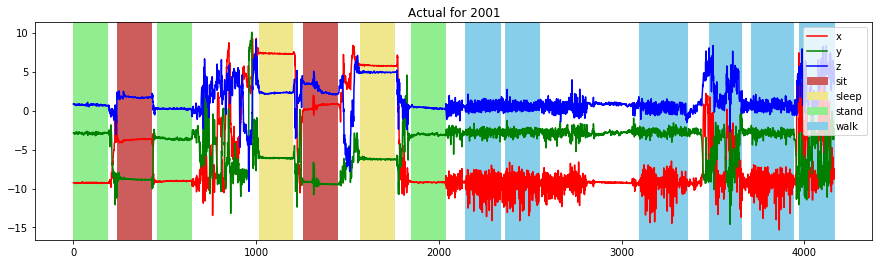

0.29286858974358976


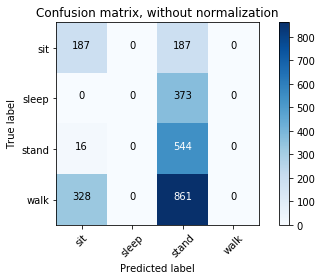

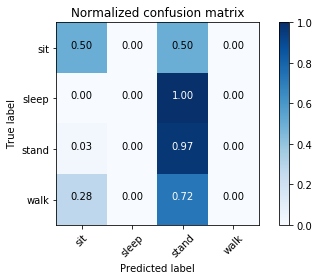

E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         sit       0.35      0.50      0.41       374
       sleep       0.00      0.00      0.00       373
       stand       0.28      0.97      0.43       560
        walk       0.00      0.00      0.00      1189

   micro avg       0.29      0.29      0.29      2496
   macro avg       0.16      0.37      0.21      2496
weighted avg       0.11      0.29      0.16      2496

Loading 3005's data
Finished prediction


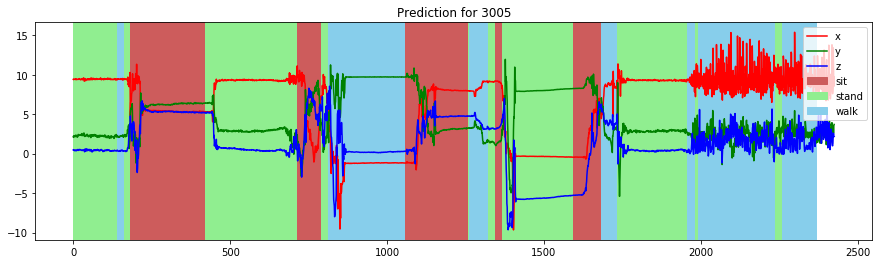

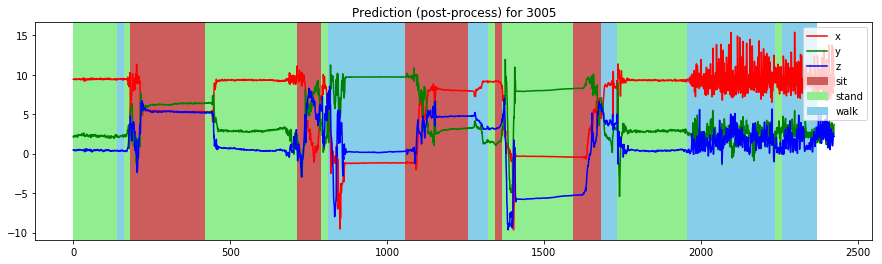

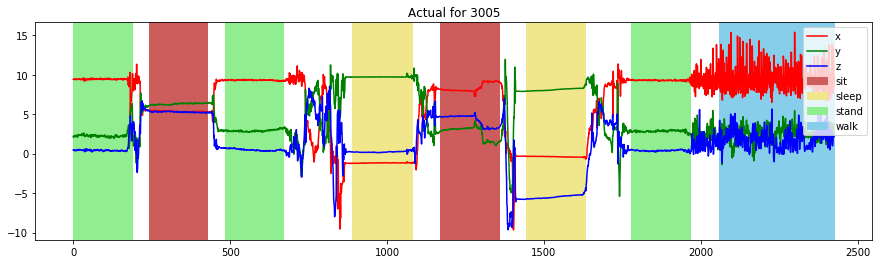

0.6703635243376463


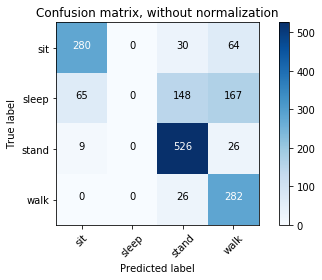

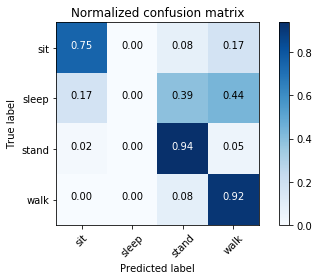

              precision    recall  f1-score   support

         sit       0.79      0.75      0.77       374
       sleep       0.00      0.00      0.00       380
       stand       0.72      0.94      0.81       561
        walk       0.52      0.92      0.67       308

   micro avg       0.67      0.67      0.67      1623
   macro avg       0.51      0.65      0.56      1623
weighted avg       0.53      0.67      0.59      1623



E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [195]:
df_y_all = call_functions(test_set, pca_tr)

Loading 2001's data
Finished prediction


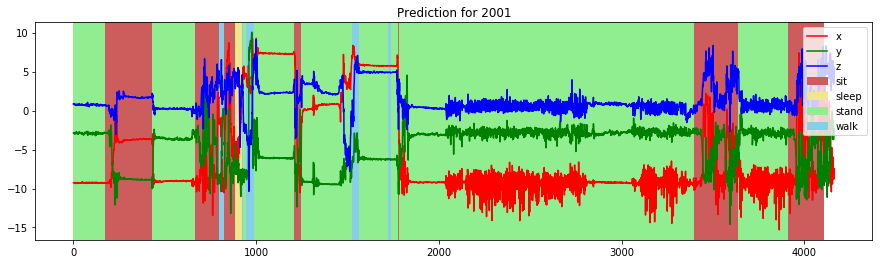

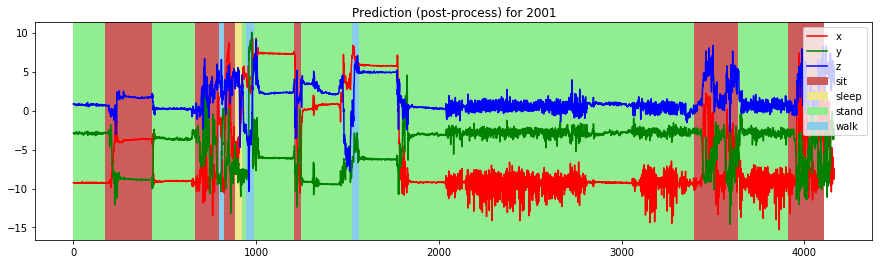

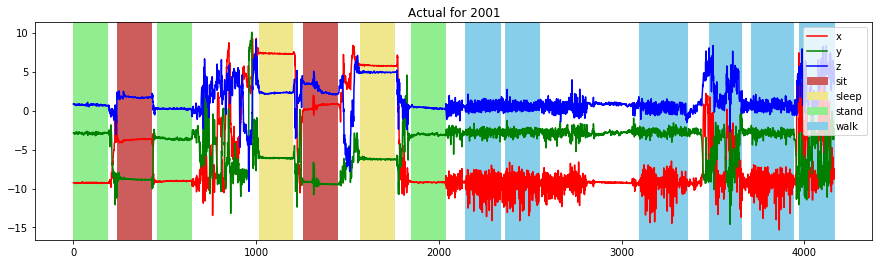

0.29286858974358976


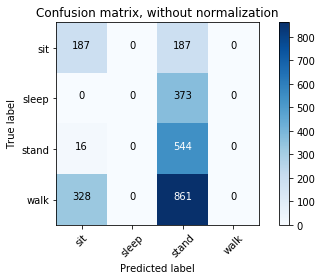

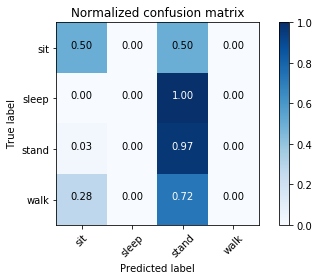

E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

         sit       0.35      0.50      0.41       374
       sleep       0.00      0.00      0.00       373
       stand       0.28      0.97      0.43       560
        walk       0.00      0.00      0.00      1189

   micro avg       0.29      0.29      0.29      2496
   macro avg       0.16      0.37      0.21      2496
weighted avg       0.11      0.29      0.16      2496

Loading 3005's data
Finished prediction


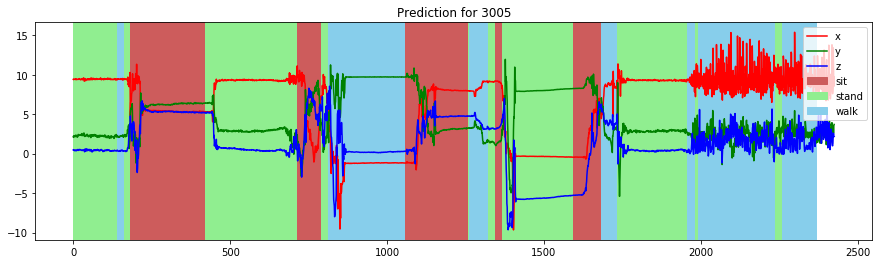

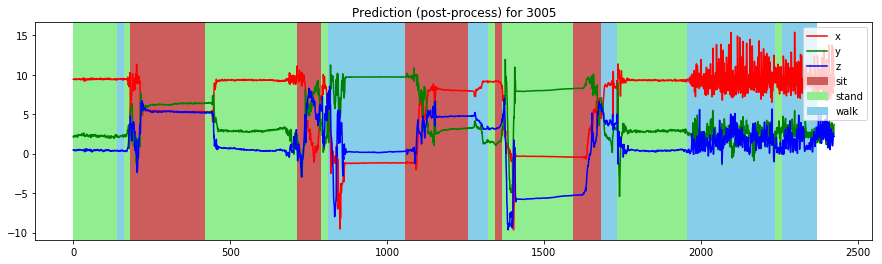

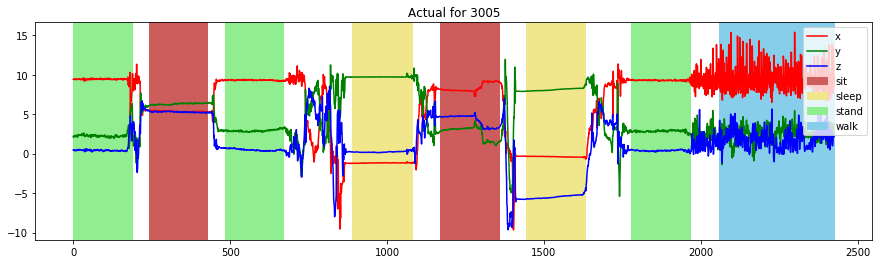

0.6703635243376463


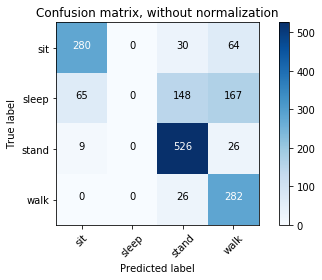

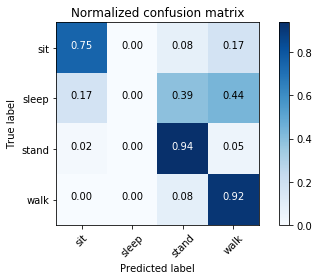

              precision    recall  f1-score   support

         sit       0.79      0.75      0.77       374
       sleep       0.00      0.00      0.00       380
       stand       0.72      0.94      0.81       561
        walk       0.52      0.92      0.67       308

   micro avg       0.67      0.67      0.67      1623
   macro avg       0.51      0.65      0.56      1623
weighted avg       0.53      0.67      0.59      1623



E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [197]:
df_y_all = call_functions_not_combine(test_set, pca_tr)

In [92]:
cols = ['x','y','z']
df_y_all

,timestamp,y_pred,y_actual
0,2019-02-10 12:18:26.57,3,2
1,2019-02-10 12:18:26.735,3,2
2,2019-02-10 12:18:26.892,3,2
3,2019-02-10 12:18:27.054,3,2
4,2019-02-10 12:18:27.215,3,2
5,2019-02-10 12:18:27.376,3,2
6,2019-02-10 12:18:27.536,3,2
7,2019-02-10 12:18:27.696,3,2
8,2019-02-10 12:18:27.856,3,2
9,2019-02-10 12:18:28.018,3,2


(8170, 3)
0.4411260709914321


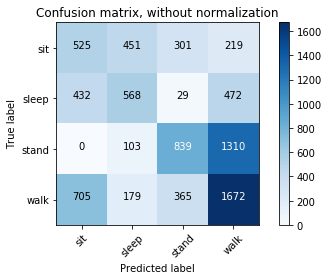

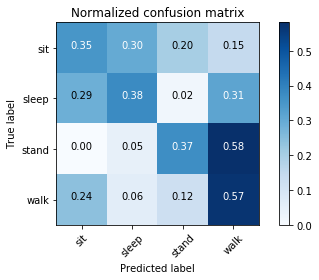

              precision    recall  f1-score   support

         sit       0.32      0.35      0.33      1496
       sleep       0.44      0.38      0.41      1501
       stand       0.55      0.37      0.44      2252
        walk       0.46      0.57      0.51      2921

   micro avg       0.44      0.44      0.44      8170
   macro avg       0.44      0.42      0.42      8170
weighted avg       0.45      0.44      0.44      8170

{'precision': 0.43865538840113055, 'recall': 0.4185786639448942, 'f1-score': 0.42206328464790555, 'support': 8170}


In [93]:
LABELS = ['sit', 'sleep', 'stand', 'walk']

df_y_notnull = df_y_all[df_y_all['y_pred']!=-1]
df_y_notnull = df_y_notnull.dropna()
df_y_notnull = df_y_notnull.reset_index(drop=True)

print(df_y_notnull.shape)

actual_y = list(df_y_notnull['y_actual'])
pred_y = list(df_y_notnull['y_pred'])

last = len(pred_y)

for i in range(len(pred_y)):
    if(pred_y[i]==-1):
        last = i
        break

pred_y = pred_y[:last]
actual_y = actual_y[:last]

acc = accuracy_score(actual_y, pred_y)
print(acc)

show_conf_matrix(actual_y, pred_y, LABELS)
show_clf_report(actual_y, pred_y, LABELS)

label_list = [0,1,2,3]
report = classification_report(actual_y, pred_y, label_list, output_dict=True)
print(report['macro avg'])

# Display Table

In [66]:
from prettytable import PrettyTable

In [149]:
# print(s)
df_y = df_y_all.copy()

df_y[:200]

,timestamp,y_pred,y_actual
0,2019-03-05 10:03:34.189,2,2
1,2019-03-05 10:03:34.347,2,2
2,2019-03-05 10:03:34.509,2,2
3,2019-03-05 10:03:34.67,2,2
4,2019-03-05 10:03:34.828,2,2
5,2019-03-05 10:03:34.99,2,2
6,2019-03-05 10:03:35.15,2,2
7,2019-03-05 10:03:35.312,2,2
8,2019-03-05 10:03:35.471,2,2
9,2019-03-05 10:03:35.633,2,2


In [167]:
label_period = []
period_list = [[] for i in range(len(LABELS))]

first = 0
keep = 0

for i in range(len(df_y)):
#     if(calc_sec(df_y.loc[i]['timestamp'].split(' ')[1])>=
#        calc_sec(df_sid.loc[0]['timestamp'].split(' ')[1]) and
#        calc_sec(df_y.loc[i]['timestamp'].split(' ')[1])<=
#        calc_sec(df_sid.loc[len(df_sid)-1]['timestamp'].split(' ')[1])):
        
    keep_lb = df_y.loc[keep]['y_pred']

    if(keep_lb!=df_y.loc[i]['y_pred']):
        label_period.append([df_y.loc[keep]['timestamp'], df_y.loc[i-1]['timestamp'], 
                             df_y.loc[i-1]['y_pred']])

        period_list[df_y.loc[i-1]['y_pred']].append([df_y.loc[keep]['timestamp'], df_y.loc[i-1]['timestamp']])

        keep = i

In [189]:
actual_label_period = []
actual_period_list = [[] for i in range(len(LABELS))]

first = 0
keep = 0

for i in range(len(df_y_notnull)):
#     if(calc_sec(df_y.loc[i]['timestamp'].split(' ')[1])>=
#        calc_sec(df_sid.loc[0]['timestamp'].split(' ')[1]) and
#        calc_sec(df_y.loc[i]['timestamp'].split(' ')[1])<=
#        calc_sec(df_sid.loc[len(df_sid)-1]['timestamp'].split(' ')[1])):
        
    keep_lb = df_y_notnull.loc[keep]['y_actual']

    if(keep_lb!=df_y_notnull.loc[i]['y_actual']):
        actual_label_period.append([df_y_notnull.loc[keep]['timestamp'], df_y_notnull.loc[i-1]['timestamp'], 
                             df_y_notnull.loc[i-1]['y_actual']])

        actual_period_list[df_y_notnull.loc[i-1]['y_actual']].append([df_y_notnull.loc[keep]['timestamp'],
                                                                    df_y_notnull.loc[i-1]['timestamp']])

        keep = i

In [190]:
label_list = ['sit', 'sleep', 'stand', 'walk']
headers = ['start', 'end', 'pred']

t = PrettyTable(headers)

for row in label_period:
#     if(calc_sec(row[1].split(' ')[1])-calc_sec(row[0].split(' ')[1])>1):
    t.add_row([row[0], row[1], label_list[row[2]]])

In [171]:
print(t)

+-------------------------+-------------------------+-------+
|          start          |           end           |  pred |
+-------------------------+-------------------------+-------+
| 2019-03-05 10:03:34.189 |  2019-03-05 10:04:07.1  | stand |
| 2019-03-05 10:04:07.262 | 2019-03-05 10:04:13.683 |  walk |
| 2019-03-05 10:04:13.842 | 2019-03-05 10:04:53.658 |  sit  |
| 2019-03-05 10:04:53.817 | 2019-03-05 10:04:57.188 |  walk |
|  2019-03-05 10:04:57.35 | 2019-03-05 10:05:37.166 | stand |
| 2019-03-05 10:05:37.326 | 2019-03-05 10:05:53.554 |  sit  |
| 2019-03-05 10:05:53.704 |  2019-03-05 10:06:30.15 | sleep |
| 2019-03-05 10:06:30.311 | 2019-03-05 10:06:33.523 | stand |
| 2019-03-05 10:06:33.683 | 2019-03-05 10:06:39.464 |  walk |
| 2019-03-05 10:06:39.622 | 2019-03-05 10:07:17.198 |  sit  |
| 2019-03-05 10:07:17.358 | 2019-03-05 10:07:55.093 | sleep |
| 2019-03-05 10:07:55.253 | 2019-03-05 10:08:00.391 | stand |
| 2019-03-05 10:08:00.552 | 2019-03-05 10:08:04.406 |  sit  |
| 2019-0

In [188]:
print(len(label_period))

label_cnt_list = [0 for i in range(len(label_list))]
for lb_p in label_period:
    label_i = lb_p[2]
    
    label_cnt_list[label_i] += 1

activity_changes = []
for i in range(len(label_list)):
    activity_changes.append([label_list[i], label_cnt_list[i]])
    
print(activity_changes)

85
[['sit', 20], ['sleep', 10], ['stand', 29], ['walk', 26]]


In [173]:
headers = ['Label', 'Activities Count']
tabl_act_chng = PrettyTable(headers)

for ac in activity_changes:
    tabl_act_chng.add_row([ac[0], ac[1]])
    
tabl_act_chng.add_row(['', ''])
tabl_act_chng.add_row(['total changes', len(label_period)])

In [174]:
print(tabl_act_chng)

+---------------+------------------+
|     Label     | Activities Count |
+---------------+------------------+
|      sit      |        20        |
|     sleep     |        10        |
|     stand     |        29        |
|      walk     |        26        |
|               |                  |
| total changes |        85        |
+---------------+------------------+


## Active Inactive Count (ALL)

In [175]:
headers = ['Label', 'Activities Count']
tabl_act = PrettyTable(headers)
inactive_table = []
active_table = []

sum = 0
sum_2 = 0
for ac in activity_changes:
    if(ac[0] == 'sit' or ac[0] == 'sleep'):
        sum += ac[1]
    else :
        sum_2 += ac[1]

tabl_act.add_row(['Inactive', sum])
tabl_act.add_row(['Active', sum_2])

In [176]:
print(tabl_act)

+----------+------------------+
|  Label   | Activities Count |
+----------+------------------+
| Inactive |        30        |
|  Active  |        55        |
+----------+------------------+


# Convert Time to String Method

In [159]:
def convert_time_to_string(sec):
    minute = math.floor(sec/60)
    sec = int(sec%60)

    time_string = str(minute) + ':' + str(sec)
    if(sec<10):
        time_string = str(minute) + ':0' + str(sec)
    
    return time_string

# Predicted Duration

In [183]:
total_secs = []
for i in range(len(period_list)):    
    secs = 0
    for p_i in period_list[i]:
        sec = calc_sec(p_i[1].split(' ')[1]) - calc_sec(p_i[0].split(' ')[1])
        secs += sec
    
    secs = round(secs, 3)
    total_secs.append(secs)
    
percent_secs = [round(t/np.sum(total_secs)*100, 3) for t in total_secs]

tb = PrettyTable(['Label', 'Minutes', 'Percentage', 'Activity Count'])

for i in range(len(LABELS)):
    tb.add_row([label_list[i], convert_time_to_string(total_secs[i]), percent_secs[i], label_cnt_list[i]])

tb.add_row(['', '', '',''])
tb.add_row(['total', convert_time_to_string(round(np.sum(total_secs), 3)), 
            round(np.sum(percent_secs), 3), len(label_period)])

# Actual Duration

In [161]:
df_lb = df_sid.groupby('label')

dura_dict = {}
for lb in label_list:
    dura_dict[lb] = 0

idx = list(df_sid.index)
for i in range(len(label_list)):
    lb = label_list[i]
    df_temp = df_lb.get_group(lb)
    df_temp = df_temp.reset_index(drop=True)
        
    if(lb=='downstairs' or lb=='upstairs'):
        lb = 'walk'
    
    for j in range(len(df_temp)):
        dura_dict[lb] += calc_sec(df_temp.loc[j]['duration'])
        
total_dura = np.sum([dura_dict[lb] for lb in label_list])

percent_list = []
        
tabl = PrettyTable(['Label', 'Minutes', 'Percentage'])
for lb in label_list:
    percent = round(dura_dict[lb]/total_dura*100, 3)
    tabl.add_row([lb, convert_time_to_string(dura_dict[lb]), round(dura_dict[lb]/total_dura*100, 3)])
    
    percent_list.append(percent)
    
tabl.add_row(['', '', ''])    
tabl.add_row(['total', convert_time_to_string(total_dura), round(np.sum(percent_list), 3)])

In [193]:
actual_label_cnt_list = [0 for i in range(len(label_list))]
for lb_p in actual_label_period:
    label_i = lb_p[2]
    
    actual_label_cnt_list[label_i] += 1

In [197]:
total_secs = []
for i in range(len(actual_period_list)):    
    secs = 0
    for p_i in actual_period_list[i]:
        sec = calc_sec(p_i[1].split(' ')[1]) - calc_sec(p_i[0].split(' ')[1])
        secs += sec
    
    secs = round(secs, 3)
    total_secs.append(secs)
    
percent_secs = [round(t/np.sum(total_secs)*100, 3) for t in total_secs]

tabl = PrettyTable(['Label', 'Minutes', 'Percentage', 'Activity Count'])

for i in range(len(LABELS)):
    tabl.add_row([label_list[i], convert_time_to_string(total_secs[i]), 
                  percent_secs[i], actual_label_cnt_list[i]])

tabl.add_row(['', '', '',''])
tabl.add_row(['total', convert_time_to_string(round(np.sum(total_secs), 3)), 
            round(np.sum(percent_secs), 3), len(actual_label_period)])

# Activity Durations Table

In [198]:
print('Prediction')
print(tb)

print('Actual')
print(tabl)

Prediction
+-------+---------+------------+----------------+
| Label | Minutes | Percentage | Activity Count |
+-------+---------+------------+----------------+
|  sit  |   8:00  |   25.543   |       20       |
| sleep |   6:27  |   20.646   |       10       |
| stand |  11:39  |   37.228   |       29       |
|  walk |   5:11  |   16.582   |       26       |
|       |         |            |                |
| total |  31:19  |   99.999   |       85       |
+-------+---------+------------+----------------+
Actual
+-------+---------+------------+----------------+
| Label | Minutes | Percentage | Activity Count |
+-------+---------+------------+----------------+
|  sit  |   4:58  |   24.221   |       10       |
| sleep |   5:00  |   24.353   |       10       |
| stand |   7:29  |   36.45    |       15       |
|  walk |   3:04  |   14.977   |       4        |
|       |         |            |                |
| total |  20:33  |  100.001   |       39       |
+-------+---------+------------+

# Bar Chart for Every 5 Minutes

In [130]:
s_idx = 0
f_idx = 1
lb_idx = 2

## Separate Each 1 Hour

In [246]:
fivemin = 60*60
new_label_period = []

start_time = calc_sec(label_period[0][s_idx].split(' ')[1])
finish_time = calc_sec(label_period[-1][f_idx].split(' ')[1])

floor_start = start_time - (start_time%fivemin)
ceil_finish = finish_time - (finish_time%fivemin) + fivemin

# print(calc_ts(floor_start), calc_ts(ceil_finish))

tm_s = floor_start
tm_f = floor_start + fivemin
date = label_period[0][s_idx].split(' ')[0]

for prd in label_period:
    start = calc_sec(prd[s_idx].split(' ')[1])
    finish = calc_sec(prd[f_idx].split(' ')[1])
    
    if(finish>=tm_f and
      start-(start%fivemin)==tm_s):
            
        new_prd = [prd[s_idx], date + ' ' + calc_ts(tm_f), prd[lb_idx]]
        new_label_period.append(new_prd)
    
    elif(start-(start%fivemin)==tm_s and
        finish-(finish%fivemin)+fivemin==tm_f):
        new_label_period.append(prd)
        
    while(finish>=tm_f):
        tm_s += fivemin
        tm_f += fivemin
                
    if(start<tm_s):
        new_prd = [date + ' ' + calc_ts(tm_s), prd[f_idx], prd[lb_idx]]
        new_label_period.append(new_prd)

In [253]:
all_periods_label = []

for t_i in range(int(floor_start), int(ceil_finish), fivemin):
    period_lb = [0 for i in range(len(LABELS))]
    for prd in new_label_period:
        if(calc_sec(prd[s_idx].split(' ')[1])>=t_i and 
           calc_sec(prd[f_idx].split(' ')[1])<=t_i+fivemin and
           prd[lb_idx]!=-1
          ):
            period_lb[prd[lb_idx]] += calc_sec(prd[f_idx].split(' ')[1])-calc_sec(prd[s_idx].split(' ')[1])
            period_lb[prd[lb_idx]] = round(period_lb[prd[lb_idx]], 3)
            
    all_periods_label.append([convert_time_to_string(i) for i in period_lb])

In [254]:
all_periods_label

[['1:44', '1:14', '2:35', '1:34'],
 ['0:00', '0:00', '0:00', '0:00'],
 ['4:34', '3:52', '6:40', '3:04'],
 ['1:40', '1:21', '1:54', '0:06']]

In [255]:
df_all = pd.DataFrame(all_periods_label, columns=label_list)
df_all = df_all.set_index(pd.Index([calc_ts(i) + '-' + calc_ts(i+fivemin) 
                           for i in range(int(floor_start), int(ceil_finish), fivemin)]))

In [256]:
df_all

,sit,sleep,stand,walk
10:0:0-11:0:0,1:44,1:14,2:35,1:34
11:0:0-12:0:0,0:00,0:00,0:00,0:00
12:0:0-13:0:0,4:34,3:52,6:40,3:04
13:0:0-14:0:0,1:40,1:21,1:54,0:06


## Plot Bar Graph

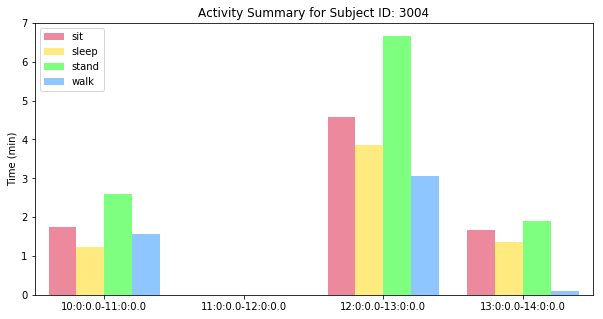

In [261]:
pos = list(range(len(df_all['sit'])))
width = 0.2
colors = ['crimson','gold','lime','dodgerblue']

fig, ax = plt.subplots(figsize=(10,5))

for i in range(len(LABELS)):
    plt.bar([p + i*width for p in pos],
            df_all[label_list[i]].apply(lambda x: calc_sec('0:' + x)/60),
            width,
            alpha=0.5,
            color=colors[i],
            label=label_list[i])
    
ax.set_xticks([p + 1.5 * width for p in pos])

xtick_labels = [calc_ts(floor_start + i*fivemin) + '-' + calc_ts(floor_start + (i+1)*fivemin)
                for i in range(len(df_all))]
ax.set_xticklabels(xtick_labels)

ax.set_ylabel('Time (min)')

plt.xlim(min(pos)-width, max(pos)+width*4)
plt.legend(loc='upper left')
plt.title('Activity Summary for Subject ID: ' + s)

plt.show()